In [ ]:
import torch
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from torch.utils.data import IterableDataset, DataLoader
from torchvision import transforms
import pathlib

import numpy as np
import pathlib
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


import warnings
import logging
import random

# Set random seed
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)  # If using GPU
torch.cuda.manual_seed_all(seed)  # If using multiple GPUs
np.random.seed(seed)
random.seed(seed)

# Ensure deterministic behavior (reduce randomness)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Suppress unnecessary warnings
warnings.filterwarnings("ignore")

# Set logging level to show only ERROR level logs
logging.getLogger().setLevel(logging.ERROR)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Clear GPU memory (if previously occupied by other programs)
torch.cuda.empty_cache()

# Set PyTorch memory allocation strategy
torch.cuda.set_per_process_memory_fraction(0.8, device=0)  # Limit GPU memory usage to 80%

from ResEmoteNet.approach.ResEmoteNet import ResEmoteNet


2025-04-17 21:56:04.742757: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-17 21:56:04.764505: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744941364.785191  251323 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744941364.791707  251323 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744941364.809203  251323 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Using device: cuda


In [2]:
data_folder = pathlib.Path('./dataset/')

### Split into Train, Validation, and Test

In [3]:
# Load test dataset
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    color_mode='grayscale',
    image_size=(64, 64),
    batch_size=16,
    shuffle=False,
    label_mode='categorical'
)

# Define PyTorch data preprocessing
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Found 7178 files belonging to 7 classes.


I0000 00:00:1744941421.120923  251323 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6


### Convert the TensonFlow data folder to PyTorch formate

In [4]:
# Custom IterableDataset subclass
class TFDatasetToTorch(IterableDataset):
    def __init__(self, tf_dataset, transform):
        self.tf_dataset = tf_dataset
        self.transform = transform

    def __iter__(self):
        for images, labels in self.tf_dataset:
            images = images.numpy()
            labels = labels.numpy()
            for i in range(len(images)):
                img = images[i]
                img = self.transform(tf.keras.preprocessing.image.array_to_img(img))
                yield img, labels[i]

# Convert TensorFlow dataset to PyTorch DataLoader
def tf_to_torch(dataset, transform):
    torch_dataset = TFDatasetToTorch(dataset, transform)
    return DataLoader(torch_dataset, batch_size=16)

# Apply transformations
test_loader = tf_to_torch(test_dataset, transform)

# Retrieve class names
class_names = test_dataset.class_names
print("Class names:", class_names)

Class names: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


## Normalization and Caching

In [5]:
# Assume class_names and device are already defined
# Create an instance of the model
model = ResEmoteNet()
model = model.to(device)

# Load pre-trained weights
model_path = "./models/best_model.pth"
checkpoint = torch.load(model_path, map_location=device)  # Load the weights file
# state_dict = checkpoint['model_state_dict']  # Extract model_state_dict
model.load_state_dict(checkpoint)  # Load the extracted state_dict
model.eval()
print("Model loaded successfully!")

Model loaded successfully!


2025-04-17 21:57:16.559249: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Test Accuracy: 7.09%
Confusion Matrix:
 [[  62   23  150  511   17  100   95]
 [   6    0    8   25   58    9    5]
 [  58   97  186  134    9  445   95]
 [1463   38   69   67    2   46   89]
 [ 151   30  207  137   10   86  612]
 [ 117   32  615  154   10  156  163]
 [  39  651   15   29    1   68   28]]


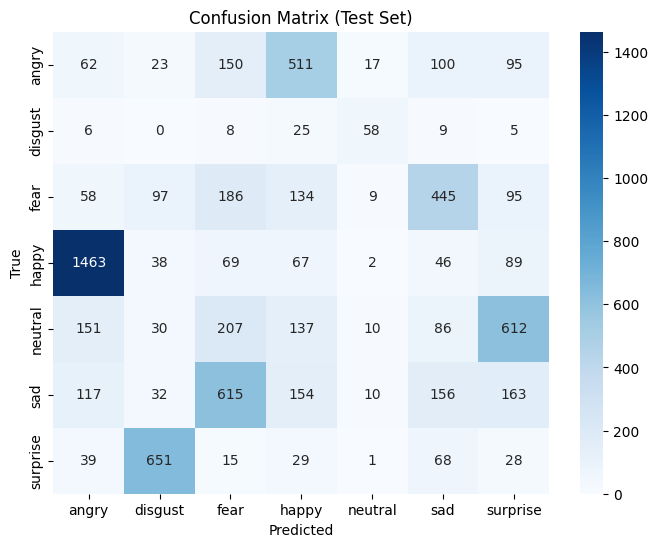

Classification Report:
               precision    recall  f1-score   support

       angry       0.03      0.06      0.04       958
     disgust       0.00      0.00      0.00       111
        fear       0.15      0.18      0.16      1024
       happy       0.06      0.04      0.05      1774
     neutral       0.09      0.01      0.01      1233
         sad       0.17      0.13      0.14      1247
    surprise       0.03      0.03      0.03       831

    accuracy                           0.07      7178
   macro avg       0.08      0.06      0.06      7178
weighted avg       0.09      0.07      0.07      7178



In [6]:
# Perform inference
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), torch.argmax(labels, dim=1).to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Confusion matrix and classification report
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=class_names))

Test Loss: 2.2652515624266094
Test Accuracy: 0.5948732237392031
Skipping confusion matrix and classification report due to missing model predictions.


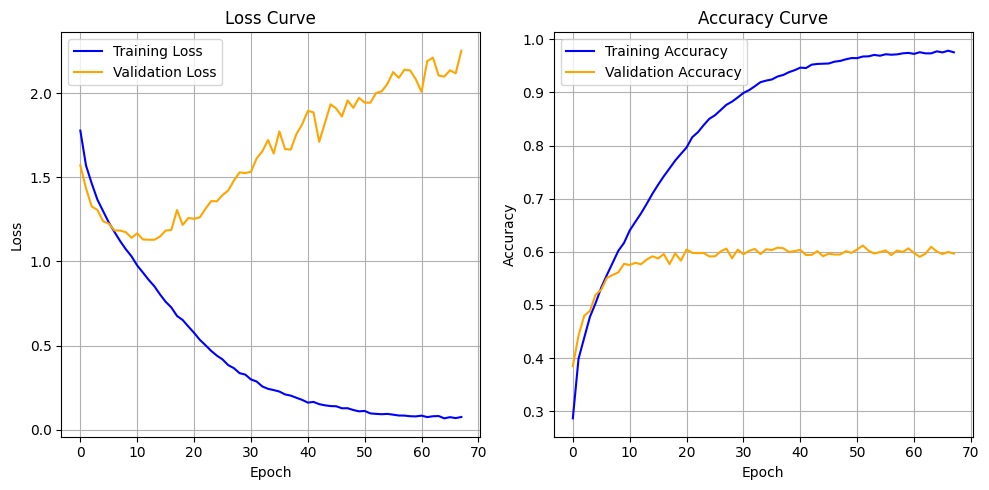

In [ ]:
# Load the CSV file
csv_file = "result_four4all.csv"  # Update path if needed
history_df = pd.read_csv(csv_file)

# Create a history object compatible with plot_training_history
class History:
    def __init__(self, df):
        self.history = {
            'loss': df['Train Loss'].tolist(),
            'val_loss': df['Validation Loss'].tolist(),
            'accuracy': df['Train Accuracy'].tolist(),
            'val_accuracy': df['Validation Accuracy'].tolist()
        }

# Mock model to return test loss and accuracy from CSV
class MockModel:
    def evaluate(self, dataset):
        # Return the last test loss and accuracy from the CSV
        return history_df['Test Loss'].iloc[-1], history_df['Test Accuracy'].iloc[-1]
    
    def predict(self, dataset):
        # Placeholder: Not used in this case
        return np.zeros((len(dataset), 1))

# Mock test_dataset 
test_dataset = []  # Empty placeholder

# Placeholder for class_names
class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3']  # Example class names

def plot_training_history(history, model):
    # Final evaluation: Calculate accuracy and loss on the test set
    test_loss, test_acc = model.evaluate(test_dataset)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_acc}")

    # Skip confusion matrix and classification report
    print("Skipping confusion matrix and classification report due to missing model predictions.")

    # Plot training curves
    plt.figure(figsize=(10, 5))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Create history object from CSV
history = History(history_df)

# Create mock model
model = MockModel()

# Call the plotting function
plot_training_history(history, model)